In [ ]:
! pip install albumentations==0.4.6

In [ ]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import  transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

Dataset Import

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
! unzip "/gdrive/MyDrive/DeepLearning/mriimages.zip"
! unzip "/gdrive/MyDrive/DeepLearning/segImages.zip"

Creating UNET Model

In [ ]:
class Double_conv(nn.Module):
  def __init__(self, in_channels, out_channels):
        super(Double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
 
  def forward(self, x):
    return self.conv(x)

In [ ]:
class UNET(nn.Module):
  def __init__(self, input_dim = 3, output_dim = 1):
        super(UNET, self).__init__()
 
        features = [64, 128, 256, 512]
 
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
 
        for feature in features:
          self.downs.append(Double_conv(input_dim,feature))
          input_dim = feature
 
        for feature in reversed(features):
          self.ups.append(
                  nn.ConvTranspose2d(feature*2, feature, 2, 2)
                        )
          self.ups.append(Double_conv(feature*2, feature))
 
        self.pool = nn.MaxPool2d(2, 2)
 
        self.bottom = Double_conv(512, 1024)
        
        self.final = nn.Conv2d(64, output_dim, 1)
  
  def forward(self, x):
    skip_list = []
 
    for down in self.downs:
      x = down(x)
      skip_list.append(x)
      x = self.pool(x)
 
    x = self.bottom(x)
 
    skip_list = skip_list[::-1]
 
    for up in range(0, len(self.ups), 2):
      x = self.ups[up](x)
      skip_val = skip_list[up//2]
      if x.shape != skip_val.shape:
        x = TF.resize(x, size=skip_val.shape[2:])
 
      x = T.cat((skip_val, x), 1)
      x = self.ups[up+1](x)
 
    x = self.final(x)
 
    return x

Importing the Datasets

In [ ]:
class Heart_dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        
        self.images = os.listdir(image_dir)
        self.masks = ["seg" + a for a in self.images]
 
    def __len__(self):
        return len(self.images)
 
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = cv2.imread(img_path,0)
        mask = cv2.imread(mask_path,0)

        image = np.reshape(image, (256,256,1))
        _,mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
        mask = mask.astype(np.float32)/255.0
 
        if self.transforms is not None:
            aug = self.transforms(image=image, mask=mask)
            image = aug["image"]
            mask = aug["mask"]
 
        return image, mask

In [ ]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 4
 
train_transform = A.Compose([A.Resize(height=256,width=256),
                             A.Rotate(limit=30,p=1.0,border_mode=cv2.BORDER_CONSTANT),A.HorizontalFlip(p=0.5),
                             A.VerticalFlip(p=0.1),A.Normalize((0),(1), 255.0),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(height=256,width=256),
                           A.Normalize((0),(1), 255.0),
                           ToTensorV2()])

dir_img = "/content/mriimages"
dir_mask = "/content/segImages"
 
img_list = os.listdir(dir_img)
mask_list = os.listdir(dir_mask)
 
size = list(range(len(img_list)))
np.random.shuffle(size)
train_idx, val_idx = size[200:], size[10:200]
 
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_data = Heart_dataset(dir_img, dir_mask, train_transform)
train_loader = DataLoader(train_data, BATCH_SIZE, sampler = train_sampler)
 
val_data = Heart_dataset(dir_img, dir_mask, val_transform)
val_loader = DataLoader(val_data, BATCH_SIZE, sampler=val_sampler)

In [ ]:
def check(model):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  min = 0.9
  model.eval()

  with T.no_grad():
    for i, (x, y) in enumerate(val_loader):
        x = x.to("cuda")
        y = y.unsqueeze(1).to("cuda")
        with T.cuda.amp.autocast():
          preds = T.sigmoid(model(x))
          preds = (preds > 0.5).float()
        num_correct += (preds == y).sum()
        num_pixels += T.numel(preds)
        dice_score += ((2.0 * (preds * y).sum()) / ((preds + y).sum() + 1e-8))
    dice_score = dice_score / len(val_loader)
    print(f"Got {num_correct}/{num_pixels} with acc {(num_correct/num_pixels)*100:.2f}")
    print("\n")
    print(f"episode {ep} Dice score: {dice_score}")
    model.train()

    if dice_score > min:
      checkpoint = {
              "state_dict": model.state_dict(),
          } 
      min = dice_score
      #T.save(checkpoint, "my_checkpoint.pth.tar")
      #save_predictions_as_imgs(val_loader, model, folder="saved_images/", device="cuda")

In [ ]:
model = UNET(1, 1).to("cuda")
#chkpt = T.load("/content/single_class_heart.pth.tar")

model.load_state_dict(chkpt["state_dict"])
model=model.cuda()

loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

scaler = T.cuda.amp.GradScaler()

for ep in range(30):
  model.train()
  loop = tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(loop):
    data = data.to("cuda")
    target = target.float().unsqueeze(1).to("cuda")

    with T.cuda.amp.autocast():
      pred = model.forward(data)
      err = loss(pred, target)
      
    optimizer.zero_grad()
    scaler.scale(err).backward()
    scaler.step(optimizer)
    scaler.update()

    loop.set_postfix(loss=err.item())
  print("Trained one epoch")
  check(model)

In [ ]:
checkpoint = {
              "state_dict": model.state_dict(),
          }
T.save(checkpoint, "/gdrive/MyDrive/DeepLearning/single_class_heart.pth.tar")

Test Data Dice Score: 0.9591543078422546


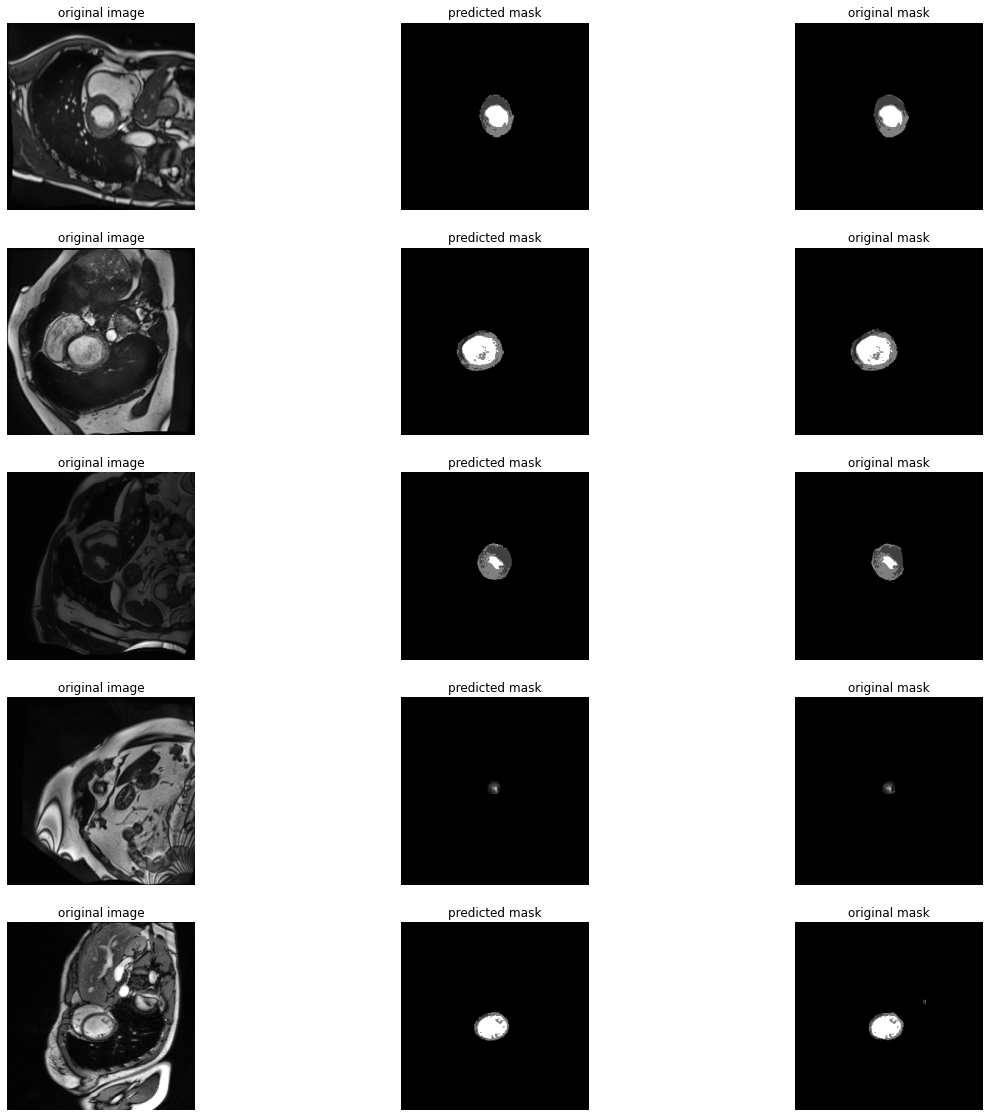

In [ ]:
import matplotlib.pyplot as plt
test_transform = A.Compose([A.Resize(height=256,width=256),
                           A.Normalize((0),(1)),
                           ToTensorV2()])
test_idx = size[:10]
test_sampler = SubsetRandomSampler(test_idx)
test_data = Heart_dataset(dir_img, dir_mask, test_transform)
test_loader = DataLoader(test_data, batch_size=1,sampler=test_sampler)

chkpt = T.load("/content/single_class_heart.pth.tar")
model.load_state_dict(chkpt["state_dict"])
model=model.cuda()
scaler = T.cuda.amp.GradScaler()

model.eval()
num_correct = 0
num_pixels = 0
dice_score = 0
row = 5
columns = 3
fig=plt.figure(figsize=(20, 20))
# iterate over test data
for batch_idx, (images, labels) in enumerate(test_loader):
# move tensors to GPU if CUDA is available
    if batch_idx == 5:
      break
    labels = labels.unsqueeze(1)
    images, labels = images.cuda(), labels.cuda()
# forward pass: compute predicted outputs by passing inputs to the model
    with T.cuda.amp.autocast():
        output = T.sigmoid(model(images))
        output = (output>0.5).float()

    num_correct += (output == labels).sum()
    num_pixels += T.numel(output)
    dice_score += (2*(output*labels).sum())/((output+labels).sum() + 1e-8)
    image,target,output = images.cpu()[0].numpy()[0],labels.cpu()[0].numpy()[0], output.cpu()[0].numpy()[0]
    target = cv2.bitwise_and(image,target)
    output = cv2.bitwise_and(image,output)

    image,target,output = image*255, target*255, output*255

    fig.add_subplot(row, columns, batch_idx*columns + 1)
    plt.axis('off') 
    plt.title("original image")
    plt.imshow(image, cmap='gray')
    
    fig.add_subplot(row, columns, batch_idx*columns + 2)
    plt.axis('off') 
    plt.title("predicted mask")
    plt.imshow(target, cmap=plt.cm.gray)
    
    fig.add_subplot(row, columns, batch_idx*columns + 3)
    plt.axis('off') 
    plt.title("original mask")
    plt.imshow(output, cmap=plt.cm.gray)

dice_score = dice_score/(0.5 * len(test_loader))
print("Test Data Dice Score:",dice_score.item())

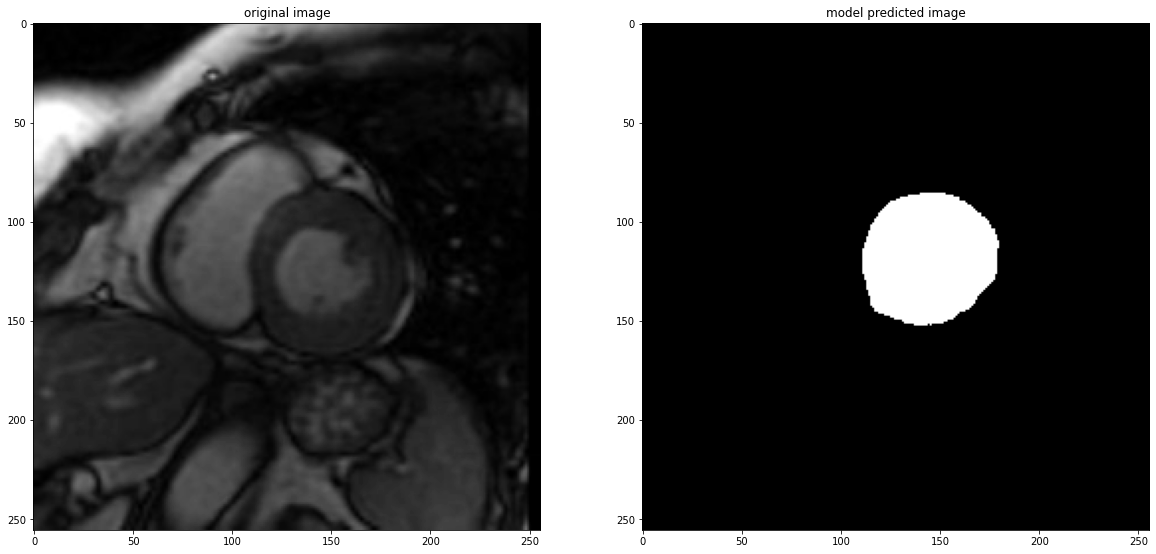

In [ ]:
test_image = cv2.imread('/gdrive/MyDrive/DeepLearning/random.jpg', 0)

test_image = cv2.resize(test_image,(256, 256))
test_image = np.reshape(test_image, (256, 256, 1))
a = A.Compose([A.Resize(height=256,width=256),
                           A.Normalize((0),(1), 255.0),
                           ToTensorV2()])
r = a(image=test_image)
test_image = r['image']

test_image = test_image.unsqueeze(0)
test_image = test_image.to('cuda')

with T.cuda.amp.autocast():
        t_output = T.sigmoid(model(test_image))
        t_output = (t_output>0.5).float()
 
t_output,test_image = t_output.cpu()[0].numpy()[0], test_image.cpu()[0].numpy()[0]
t_output,test_image = t_output*255, test_image*255

f=plt.figure(figsize=(20, 20))

f.add_subplot(1, 2, 1)
plt.title("original image")
plt.imshow(test_image, cmap='gray')

f.add_subplot(1, 2, 2)
plt.title("model predicted image")
plt.imshow(t_output, cmap='gray')